### Project 3: March Madness
#### Robert Manriquez

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

import itertools

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss, r2_score, classification_report, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Using the updated datasets with 2018 data.

df_reg = pd.read_csv('./RegularSeasonDetailedResults_Prelim2018_Edited.csv')

df_NCAA = pd.read_csv('./NCAATourneyDetailedResults_Edited.csv')

sample_sub = pd.read_csv('./SampleSubmissionStage1.csv')
stage2_sample_sub = pd.read_csv('./SampleSubmissionStage2.csv')

team_names_2017bpi = pd.read_csv('./TeamNames_Converted_2017BPI.csv')
team_names_2018bpi = pd.read_csv('./TeamNames_Converted_2018BPI.csv')

#### My general strategy for this problem is to first assemble a training set we can model with.  Below is my MMDataPrep program, where it converts the game rows from just being from the winner's perspective to two split rows, each from the winner's and loser's perspective, then adds the "Won" column as our target.  All of the oirignal rows are Won = 1, which is implied from the data.  The split rows are Won = 0.

In [3]:
def MMDataPrep(input_df):
    games = []
    for row in input_df.to_dict('records'):

        for perspective in ['W', 'L']:

            game = {}
            game['Won'] = int(perspective == 'W')

            if perspective == 'W':

                team_letter = 'W'
                opp_letter = 'L'

            else:
                team_letter = 'L'
                opp_letter = 'W'

            winner_location = row['WLoc']

            if winner_location == 'A':
                loser_location = 'H'
            elif winner_location == 'H':
                loser_location = 'A'
            elif winner_location == 'N':
                loser_location = 'N'

            row['LLoc'] = loser_location

            team_stats = [k for k,v in row.items() if k[0] == team_letter]
            opp_stats = [k for k,v in row.items() if k[0] == opp_letter]

            for stat in team_stats:
                game['Team' + stat[1:]] = row[stat]
            for stat in opp_stats:
                game['Opp' + stat[1:]] = row[stat]

            for general_stat in ['DayNum','NumOT','Season']:
                game[general_stat] = row[general_stat]

            games.append(game)
            
    return pd.DataFrame(games)

- These cells have a few functions I made to streamline the process.  StatGrabber pulls the stats of each team from a specified season and puts them into a groupby, giving me all of the mean stats from Regular Season and the Tournament stats.  Later versions allow me to chose to include tournaments seeds, Number of Wins from the NCAA tournament, and a the Basketball Power Index of each Team (BPI).

- Also included are SingleMerger and MatchMaker, which are functions I used to build my training set.  It extracts the target Team ID's and converts them into matchups, then merges the stats for individual years from StatGrabber.  With this suite of functions, I can take a modular approach to which seasons I want to model, whether to include Reg and/or Tourney games, teams seeds, and BPI.

- To probe the affects of my modeling decisions, I made a function called "QuickModelScreen," which performs a quick cross validation over KNN, Decision Tree, and LogReg classifiers to give me an idea of how well my model is doing based on what seasons and features I'm including.

In [4]:
team_names_2017bpi.head(5)

,TeamID,TeamName,FirstD1Season,LastD1Season,BPI
0,1101,Abilene Christian,2014,2018,-8.8
1,1102,Air Force,1985,2018,-5.4
2,1103,Akron,1985,2018,5.0
3,1104,Alabama,1985,2018,7.8
4,1105,Alabama A&M,2000,2018,-19.2


In [5]:
def StatGrabber(input_df, input_year_list, record_type = False):
    
    """ input_df :  Parent dataset, either RegularSeasonDetailedResultsEdited.csv or NCAATourneyDetailedResults_Edited.csv
        input_year_list : form of a list, really just something like "[2014]", only optimized to work one year at a time.
        record_type : Specify 'Reg' or 'NCAA' to add the str to each column label, help keep track of what stat belongs to which team.
    """
    
    year_list = input_year_list
    
    if record_type:
        record_type = "_" + str(record_type)
    else:
        record_type = ""
        
    loop_df = pd.DataFrame()
    for year in year_list:

        loop_cols = [col for col in input_df.columns if "Team" in col and "Opp" not in col]
        loop_cols.append('Won')

        stat_df = input_df.loc[input_df['Season'] == int(year),loop_cols].copy()

        group_stat_df = stat_df.copy().groupby('TeamTeamID').mean().rename(columns = {'Won': "WinRate"})

        rename_dict = {}
        for col in group_stat_df.columns:
            rename_dict[col] = str(year) + str(record_type) + "_" + str(col).replace("Team","")
        
        group_stat_df.rename(columns = rename_dict, inplace = True)

    return group_stat_df
    
def SeedMapper(input_df, input_year_list, int_seeds = False):  ## Need to modify this to map without relying on season the list!
    
    year_list = input_year_list
    
    W_team_seeds = []
    
    for year in year_list:
        print(year)
        for idx, teamid in enumerate(input_df.index):

            try:
                W_team_seeds.append(seed_dict[str(year)][int(teamid)])

            except:
                W_team_seeds.append('No_Seed')

    for year in year_list:                
        input_df['TeamSeed'] = W_team_seeds
    
    if int_seeds:
        input_df['TeamSeed'] = input_df['TeamSeed'].map(lambda x: 17 if x == 'No_Seed' else int(x[1:3]))
    
    return input_df

def SingleMerger(df1, df2):
    m1 = pd.merge(left = df1.copy(), right = df2.copy(), left_on = 'TeamTeamID', how = 'left', right_index = True)
    m2 = pd.merge(left = m1.copy(), right = df2.copy(), left_on = 'OppTeamID', how = 'left', right_index = True, suffixes={"_Winner", "_Loser"})
    return m2.copy()

def MatchMaker(input_df):
    # Might want to add the "201X_" year string later.
    match_df = input_df.copy()
    match_df['Match'] = match_df['TeamTeamID'].astype(str) + "_" + match_df['OppTeamID'].astype(str)
    match_df.drop(['TeamTeamID', 'OppTeamID'], axis = 1, inplace = True)
    return match_df.copy()

def QuickModelScreen(input_df, input_cv = 3):
    X = train_df.copy().drop('Won', axis = 1).set_index('Match')
    y = train_df['Won'].copy()
    
    ss_cv = StandardScaler()
    Xs = ss_cv.fit_transform(X)
    
    X_train, X_hold, y_train, y_hold = train_test_split(X,y, test_size = 0.25, random_state = 1)
    
    ss = StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_hold = ss.transform(X_hold)
    
    model = LogisticRegressionCV(Cs = np.logspace(-3,3,7), cv = input_cv)
    model.fit(Xs_train, y_train)
    
    print("LogReg :  train score :", model.score(Xs_train, y_train).round(2), "| Holdout Score:", model.score(Xs_hold, y_hold).round(2),\
          "| CV score:", cross_val_score(model, Xs,y, cv =input_cv).mean().round(2))
    
    model = DecisionTreeClassifier()
    model.fit(Xs_train, y_train)
    
    print("Tree   :  train score :", model.score(Xs_train, y_train).round(2), "| Holdout Score:", model.score(Xs_hold, y_hold).round(2),\
          "| CV score:", cross_val_score(model, Xs,y, cv =input_cv).mean().round(2))
    
    model = KNeighborsClassifier()
    model.fit(Xs_train, y_train)
    
    print("KNN    :  train score :", model.score(Xs_train, y_train).round(2), "| Holdout Score:", model.score(Xs_hold, y_hold).round(2),\
          "| CV score:", cross_val_score(model, Xs,y, cv =input_cv).mean().round(2))
    
seed = pd.read_csv('./NCAATourneySeeds_SampleTourney2018.csv')
seed_year_list = [2012, 2013,2014,2015,2016,2017, 2018]

loop_df = pd.DataFrame()
seed_dict = {}
for year in seed_year_list:
    loop_df = seed.loc[seed['Season'] == year,:].copy()
    seed_dict[str(year)] = loop_df.loc[:,['TeamID','Seed']].set_index('TeamID').to_dict()['Seed']

In [6]:
def StatGrabber_withSeed_withNCAA(input_df, input_year_list, record_type = False):

    year_list = input_year_list
    
    if record_type:
        record_type = "_" + str(record_type)
    else:
        record_type = ""
        
    loop_df = pd.DataFrame()
    for year in year_list:

        loop_cols = [col for col in input_df.columns if "Team" in col and "Opp" not in col]
        loop_cols.append('Won')

        stat_df = input_df.loc[input_df['Season'] == int(year),loop_cols].copy()
        stat_df = pd.concat([stat_df, pd.get_dummies(stat_df['TeamLoc'], prefix = "Loc_WinRate")], axis = 1)
         
        group_stat_df = stat_df.copy().groupby('TeamTeamID').mean().rename(columns = {'Won': "WinRate"})
        
        loop_seed_df = seed.loc[seed['Season']== year, :].drop('Season', axis = 1).rename(columns = {"TeamID":"TeamTeamID"}).set_index("TeamTeamID")
        
        group_stat_df = pd.merge(left = group_stat_df, right = loop_seed_df, how = 'left', left_index = True, right_index = True).fillna("No_Seed")
        
        group_stat_df['Seed'] = group_stat_df['Seed'].map(lambda x: 17 if x == 'No_Seed' else int(x[1:3]))
        
        rename_dict = {}
        for col in group_stat_df.columns:
            rename_dict[col] = str(year) + str(record_type) + "_" + str(col).replace("Team","")
        
        group_stat_df.rename(columns = rename_dict, inplace = True)
        
#         NCAA_stats_loop_df = df_NCAA.loc[df_NCAA['Season'] == year,['TeamTeamID','Won']].groupby('TeamTeamID').sum().rename(columns = {'Won': str(year)+"_NumNCAAWins"})
#         group_stat_df = pd.merge(left = group_stat_df, right = NCAA_stats_loop_df, how = 'left', left_index = True, right_index = True).fillna(0)
        
    return group_stat_df

def StatGrabber_withSeedNCAABPI(input_df, input_year_list, record_type = False):
    
    """ input_df :  Parent dataset, either RegularSeasonDetailedResultsEdited.csv or NCAATourneyDetailedResults_Edited.csv
        input_year_list : form of a list, really just something like "[2014]", only optimized to work one year at a time.
        record_type : Specify 'Reg' or 'NCAA' to add the str to each column label, help keep track of what stat belongs to which team.
    """
    year_list = input_year_list
    
    if record_type:
        record_type = "_" + str(record_type)
    else:
        record_type = ""
        
    loop_df = pd.DataFrame()
    for year in year_list:

        loop_cols = [col for col in input_df.columns if "Team" in col and "Opp" not in col]
        loop_cols.append('Won')

        stat_df = input_df.loc[input_df['Season'] == int(year),loop_cols].copy()
        stat_df = pd.concat([stat_df, pd.get_dummies(stat_df['TeamLoc'], prefix = "Loc_WinRate")], axis = 1)
         
        group_stat_df = stat_df.copy().groupby('TeamTeamID').mean().rename(columns = {'Won': "WinRate"})
        
        loop_seed_df = seed.loc[seed['Season']== year, :].drop('Season', axis = 1).rename(columns = {"TeamID":"TeamTeamID"}).set_index("TeamTeamID")
        
        group_stat_df = pd.merge(left = group_stat_df, right = loop_seed_df, how = 'left', left_index = True, right_index = True).fillna("No_Seed")
        
        group_stat_df['Seed'] = group_stat_df['Seed'].map(lambda x: 17 if x == 'No_Seed' else int(x[1:3]))
        
        rename_dict = {}
        for col in group_stat_df.columns:
            rename_dict[col] = str(year) + str(record_type) + "_" + str(col).replace("Team","")
        
        group_stat_df.rename(columns = rename_dict, inplace = True)
        
#         NCAA_stats_loop_df = df_NCAA.loc[df_NCAA['Season'] == year,['TeamTeamID','Won']].groupby('TeamTeamID').sum().rename(columns = {'Won': str(year)+"_NumNCAAWins"})
#         group_stat_df = pd.merge(left = group_stat_df, right = NCAA_stats_loop_df, how = 'left', left_index = True, right_index = True).fillna(0)
        

        if year == 2017:
            group_stat_df = pd.merge(left = group_stat_df, right = team_names_2017bpi.loc[:,['TeamID', 'BPI']],\
                                     how = 'left', left_index = True, right_on = 'TeamID').copy().rename(columns = {'BPI': str(year)+"_BPI"})
        if year == 2018:
            group_stat_df = pd.merge(left = group_stat_df, right = team_names_2018bpi.loc[:,['TeamID', 'BPI']],\
                                     how = 'left', left_index = True, right_on = 'TeamID').copy().rename(columns = {'BPI': str(year)+"_BPI"})
            
        group_stat_df = group_stat_df.set_index('TeamID', drop = True)
        
        
    return group_stat_df

In [7]:
def Submission_IDMaker(input_df):
    match_df = input_df.copy()
    match_df['ID'] = match_df['Season'].astype(str) + "_" + match_df['TeamTeamID'].astype(str) + "_" + match_df['OppTeamID'].astype(str)
    match_df.drop(['TeamTeamID', 'OppTeamID','Season'], axis = 1, inplace = True)
    return match_df.copy()

#### Lastly, to obtain the BPI, I scraped ESPN's website to grab the data for 2017 and 2018, then converted them to usable csv files.  The team names ESPN uses are different from Kaggle's data, so it was necessary to edit the names so that they matched to merge the data successfully.

In [8]:
from bs4 import BeautifulSoup
from selenium import webdriver
from time import sleep

def BPIScraper():
    
    driver = webdriver.Chrome()
    bpi_df = pd.DataFrame()
    
    for page in range(1,16):
        print(page)
        # Using this url, I can specify which season I want manually in the /bpi/season/["201X"]/page/ field.
        driver.get('http://www.espn.com/mens-college-basketball/bpi/_/view/bpi/season/2017/page/' + str(page))

        html = driver.page_source
        soup = BeautifulSoup(html, 'lxml')

        team_names = []
        for name in soup.find_all('span', {'class':'team-names'}):
            team_names.append(name.text)

        bpi_list = []
        for i in soup.find_all('tbody')[1].find_all('tr'):
            bpi_list.append(i.find_all('td')[6].text)

        loop_df = pd.DataFrame({
            "TeamName":team_names,
            "BPI":bpi_list
        })

        bpi_df = pd.concat([bpi_df,loop_df], axis = 0).copy()
        sleep(3)
        print(page, "done")
    
    bpi_df.reset_index(drop = True).to_csv('FILENAME.csv',index = False)

In [9]:
################################ ################################ ################################ ################################
# Doing a 4th sub, using Reg Season data for 2013,2014,2015,2016,2017 with seeds from each respective NCAA tourney.
# Mar13 12pm added Team Loc data dummies, knn tuned got a little worse but logreg improved
# Mar12:33pm added NCAA wins using StatGrabber_withSeed_withNCAA, have to drop out 2017 wins.  So far looks decent, not overfitting too much.

target_df_reg = df_reg.loc[df_reg['Season'] == 2017, ['TeamTeamID', 'OppTeamID', 'Won']].reset_index(drop = True).copy()
target_df_ncaa = df_NCAA.loc[df_NCAA['Season'] == 2017, ['TeamTeamID', 'OppTeamID', 'Won']].reset_index(drop = True).copy()
target_df = pd.concat([target_df_reg, target_df_ncaa], axis = 0)

target_df['Won'] = 1 - target_df['Won']

regstats2013_with_seed = StatGrabber_withSeed_withNCAA(df_reg,[2013], 'Reg')
regstats2014_with_seed = StatGrabber_withSeed_withNCAA(df_reg,[2014], 'Reg')
regstats2015_with_seed = StatGrabber_withSeed_withNCAA(df_reg,[2015], 'Reg')
regstats2016_with_seed = StatGrabber_withSeed_withNCAA(df_reg,[2016], 'Reg')
regstats2017_with_seed = StatGrabber_withSeed_withNCAA(df_reg, [2017], 'Reg')

train_df = SingleMerger(target_df, regstats2013_with_seed).copy()
train_df = SingleMerger(train_df, regstats2014_with_seed).copy()
train_df = SingleMerger(train_df, regstats2015_with_seed).copy()
train_df = SingleMerger(train_df, regstats2016_with_seed).copy()
train_df = SingleMerger(train_df, regstats2017_with_seed).copy()

train_df = MatchMaker(train_df).copy()

train_df['2017_Reg_Seed_Diff'] = train_df['2017_Reg_Seed_Winner'] - train_df['2017_Reg_Seed_Loser']
train_df['2016_Reg_Seed_Diff'] = train_df['2016_Reg_Seed_Winner'] - train_df['2016_Reg_Seed_Loser']
train_df['2015_Reg_Seed_Diff'] = train_df['2015_Reg_Seed_Winner'] - train_df['2015_Reg_Seed_Loser']
train_df['2014_Reg_Seed_Diff'] = train_df['2014_Reg_Seed_Winner'] - train_df['2014_Reg_Seed_Loser']
train_df['2013_Reg_Seed_Diff'] = train_df['2013_Reg_Seed_Winner'] - train_df['2013_Reg_Seed_Loser']

train_df.dropna(inplace=True)  # These merges result in some match ups being made that didn't occur in the training data, so we're dropping them.

QuickModelScreen(train_df)

X = train_df.copy().drop('Won', axis = 1).set_index('Match')
y = train_df['Won'].copy()

X_train, X_hold, y_train, y_hold = train_test_split(X,y, test_size = 0.25, random_state = 1)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_hold = ss.transform(X_hold)

knn = KNeighborsClassifier(n_neighbors=15, weights='uniform')  #keeping knn n=15
knn.fit(Xs_train, y_train) 

print("KNN tuned:  train score :", knn.score(Xs_train, y_train).round(2), "| Holdout Score:", knn.score(Xs_hold, y_hold).round(2),\
      "| CV score:", cross_val_score(knn, Xs_hold,y_hold, cv =8).mean().round(2))

lr = LogisticRegressionCV(Cs = np.linspace(0.001,1,50), cv = 10)
lr.fit(Xs_train, y_train) 

print("LR tuned:  train score :", lr.score(Xs_train, y_train).round(2), "| Holdout Score:", lr.score(Xs_hold, y_hold).round(2),\
      "| CV score:", cross_val_score(lr, Xs_hold,y_hold, cv =8).mean().round(2), lr.C_)

LogReg :  train score : 0.76 | Holdout Score: 0.74 | CV score: 0.74
Tree   :  train score : 0.91 | Holdout Score: 0.63 | CV score: 0.62
KNN    :  train score : 0.77 | Holdout Score: 0.65 | CV score: 0.65
KNN tuned:  train score : 0.74 | Holdout Score: 0.67 | CV score: 0.68
LR tuned:  train score : 0.76 | Holdout Score: 0.74 | CV score: 0.73 [0.02138776]


In [10]:
log_loss(y_train, lr.predict_proba(Xs_train)), log_loss(y_hold, lr.predict_proba(Xs_hold))

(0.4883924755341129, 0.5160257777010474)

- Looking at both metrics of accuracy and log loss, since Kaggle is grading on log loss, which punishes more for incorrect predictions rather than just conventional accuracy.

In [11]:
train_df.shape

(10710, 197)

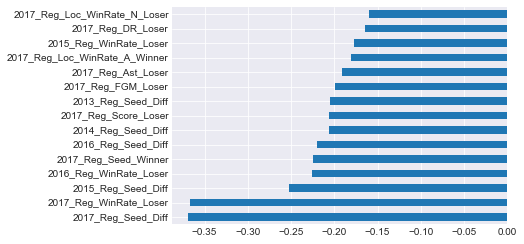

In [12]:
train_df.corr()['Won'].sort_values(ascending = True)[0:15].plot(kind = 'barh')

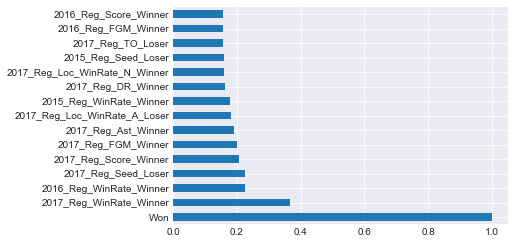

In [13]:
train_df.corr()['Won'].sort_values(ascending = False)[0:15].plot(kind = 'barh')

- So far, the stats that matter the most are WinRates, the Seeds and Seed Differences, Field Goals Made, Assists, and Average Score per season.  This makes sense, since typically teams with higher points per season will also win more often, and typically most point made are through field goals and assists, so team that are more efficient at scoring in these manners have a stronger correlation on the model.
    -  Winrates seem to matter less at neutral games, WinRate at Away games seems to matter the most of the three.
    -  The rest of the stats could be just noise, since these tops stats are somewhat resultant of the others.
    
#### The next step is to incorporate the BPI, which is an aggregate rank ESPN calculates based on team strength in terms of offense and defense stats, but also how hard the team's schedule is for the season, how well they play with travel, how far and often they travel, and a whole slew of other stats that go beyond my domain knowledge in the NCAA.

- From manual tests, I found that using more data from years prior resulted in lower accuracies and higher log loss, so for my final Kaggle predictions I switched to just using data from 2018.  I've trained my model on the regular season data, added the NCAA Tourney seeds, and included the BPI for 2018.  I continued with RandomForest.  I chose to use the ensemble method RandomForest because it doesn't require scaling, allows for a 'whitebox' transparency to it's decision making, and I feel is superior to using a single DecTree for a dataset this large.

- Since Kaggle is scoring on log_loss, we're going to be scoring using log_loss in our crossvalidations.

In [14]:
target_df = df_reg.loc[df_reg['Season'] == 2018, ['TeamTeamID', 'OppTeamID', 'Won']].reset_index(drop = True).copy()

target_df['Won'] = 1 - target_df['Won']

regstats2016_with_seed = StatGrabber_withSeed_withNCAA(df_reg, [2016], 'Reg')
regstats2017_with_seed = StatGrabber_withSeedNCAABPI(df_reg, [2017], 'Reg')
regstats2018_with_seed = StatGrabber_withSeedNCAABPI(df_reg, [2018], 'Reg')

train_df = SingleMerger(target_df, regstats2016_with_seed).copy()
train_df = SingleMerger(train_df, regstats2017_with_seed).copy()
train_df = SingleMerger(train_df, regstats2018_with_seed).copy()

train_df = MatchMaker(train_df).copy()

train_df['2016_Reg_Seed_Diff'] = train_df['2016_Reg_Seed_Winner'] - train_df['2016_Reg_Seed_Loser']
train_df['2017_Reg_Seed_Diff'] = train_df['2017_Reg_Seed_Winner'] - train_df['2017_Reg_Seed_Loser']
train_df['2018_Reg_Seed_Diff'] = train_df['2018_Reg_Seed_Winner'] - train_df['2018_Reg_Seed_Loser']

train_df['2017_BPI_Diff'] = train_df['2017_BPI_Winner'] - train_df['2017_BPI_Loser']
train_df['2018_BPI_Diff'] = train_df['2018_BPI_Winner'] - train_df['2018_BPI_Loser']

# train_df.drop([
#     '2016_Reg_Seed_Winner', '2016_Reg_Seed_Loser',\
#                '2017_Reg_Seed_Winner', '2017_Reg_Seed_Loser',\
#                '2018_Reg_Seed_Winner', '2018_Reg_Seed_Loser',\
#                 '2017_BPI_Winner','2017_BPI_Loser',\
#                 '2018_BPI_Winner','2018_BPI_Loser'\
#                 ],axis = 1, inplace = True)

X = train_df.copy().drop('Won', axis = 1).set_index('Match')
y = train_df['Won'].copy()

X_train, X_hold, y_train, y_hold = train_test_split(X,y, test_size = 0.25, random_state = 1)

forest = RandomForestClassifier(n_jobs = 3)

forest_params = {
    'max_depth' : [4,5],
    'n_estimators': [75, 100],
    'criterion': ['gini', 'entropy'],
    'max_features':[0.5, 1.0],
    'min_samples_split': [10,20,30],
    'min_samples_leaf': [1,3,5,10]
}

rs_forest = RandomizedSearchCV(forest, forest_params, scoring = 'neg_log_loss')
rs_forest.fit(X_train, y_train)

print(rs_forest.best_score_)
print(rs_forest.best_params_)
print(rs_forest.score(X_train, y_train),rs_forest.score(X_hold, y_hold))

-0.5047402181678952
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 0.5, 'max_depth': 5, 'criterion': 'entropy'}
-0.4722986300400082 -0.48771499435530496


In [15]:
QuickModelScreen(train_df, input_cv = 3)

LogReg :  train score : 0.76 | Holdout Score: 0.76 | CV score: 0.75
Tree   :  train score : 0.94 | Holdout Score: 0.65 | CV score: 0.64
KNN    :  train score : 0.79 | Holdout Score: 0.69 | CV score: 0.68


In [16]:
X = train_df.copy().drop('Won', axis = 1).set_index('Match')
y = train_df['Won'].copy()

X_train, X_hold, y_train, y_hold = train_test_split(X,y, test_size = 0.25, random_state = 1)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_hold = ss.transform(X_hold)

knn = KNeighborsClassifier(n_neighbors=15, weights='uniform')  #keeping knn n=15
knn.fit(Xs_train, y_train) 

print("KNN tuned:  train score :", knn.score(Xs_train, y_train).round(2), "| Holdout Score:", knn.score(Xs_hold, y_hold).round(2),\
      "| CV score:", cross_val_score(knn, Xs_hold,y_hold, cv =3).mean().round(2))

lr = LogisticRegressionCV(Cs = np.linspace(0.001,1,50), cv = 3)
lr.fit(Xs_train, y_train) 

print("LR tuned:  train score :", lr.score(Xs_train, y_train).round(2), "| Holdout Score:", lr.score(Xs_hold, y_hold).round(2),\
      "| CV score:", cross_val_score(lr, Xs_hold,y_hold, cv =3).mean().round(2), lr.C_)

KNN tuned:  train score : 0.75 | Holdout Score: 0.72 | CV score: 0.7
LR tuned:  train score : 0.76 | Holdout Score: 0.77 | CV score: 0.75 [0.04177551]


In [17]:
lr.coef_[0]

array([ 7.09849239e-02,  3.23413704e-02, -7.92941758e-02,  6.88401668e-02,
        4.04524008e-02, -1.84277283e-02, -5.89492678e-02,  3.23616533e-02,
       -3.63885109e-02,  1.67307814e-02,  1.94642987e-03, -4.20232282e-02,
       -5.55824007e-02, -8.92652301e-03,  9.09066350e-02,  8.03569849e-02,
       -8.10330471e-02, -2.73387906e-02,  2.19905521e-02, -3.92694401e-02,
        1.20146620e-02,  1.86403570e-02, -3.32161256e-02, -6.58485170e-02,
       -1.50930951e-02,  1.02627592e-01,  2.26690350e-02,  5.89448860e-04,
        2.59763294e-02, -5.25396859e-02,  1.46599767e-02,  9.24800711e-02,
       -1.52568467e-02, -1.04678223e-01, -8.47284968e-02,  9.66989754e-02,
        1.70743372e-02, -3.13983379e-02, -2.29676342e-02, -3.47413909e-02,
        5.37274598e-02, -1.25232929e-01,  2.62454067e-02,  4.93152266e-02,
       -5.08101728e-02, -5.76093958e-02,  6.59583858e-02,  1.21980104e-02,
       -1.28497099e-02,  4.75130006e-02,  4.27441332e-02, -1.08173134e-01,
        1.48961606e-01,  

In [25]:
pd.DataFrame({"coef":lr.coef_[0],
              "LogReg Feature": X.columns}).sort_values(by = 'coef', ascending = False).head(15)

,LogReg Feature,coef
112,2018_Reg_WinRate_Winner,0.670397
122,2018_BPI_Diff,0.366340
117,2018_BPI_Winner,0.237015
121,2017_BPI_Diff,0.231831
52,2017_Reg_WinRate_Loser,0.148962
53,2017_Reg_Loc_WinRate_A_Loser,0.110465
25,2016_Reg_FGM3_Winner,0.102628
35,2016_Reg_Loc_WinRate_H_Winner,0.096699
75,2017_Reg_Loc_WinRate_N_Winner,0.094777
31,2016_Reg_Stl_Winner,0.092480


In [19]:
train_df.shape

(9446, 125)

In [20]:
X.shape

(9446, 123)

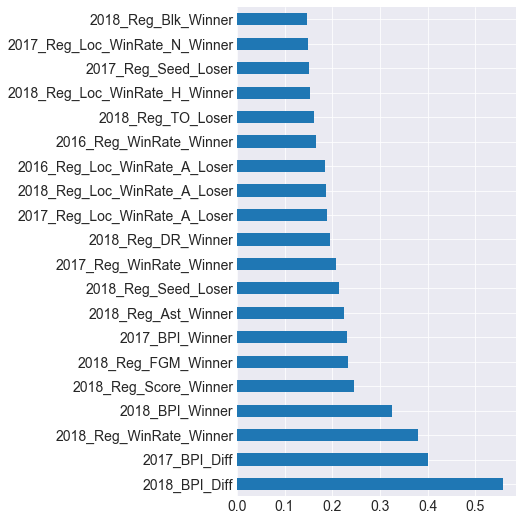

In [21]:
train_df.corr()['Won'].sort_values(ascending = False).drop('Won', axis = 0)[0:20].plot(kind = 'barh', figsize = (5,9), fontsize = 14)

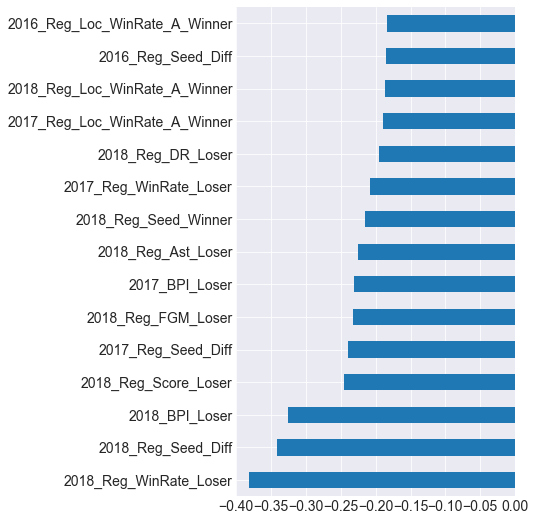

In [22]:
train_df.corr()['Won'].sort_values(ascending = True).drop('Won', axis = 0)[0:15].plot(kind = 'barh', figsize = (5,9), fontsize = 14)

In [26]:
X.shape

(9446, 123)

In [27]:
rs_forest.best_estimator_.feature_importances_

array([5.45420635e-04, 1.36248642e-03, 1.10507870e-03, 7.75883500e-04,
       9.30773589e-04, 6.59037113e-04, 6.89893742e-04, 7.96845929e-04,
       7.02408694e-04, 6.99223719e-04, 9.03889374e-04, 2.77812416e-04,
       6.00363040e-04, 9.27953400e-04, 6.33978672e-04, 3.80488796e-03,
       1.73499817e-03, 8.41995771e-04, 2.22505163e-04, 5.53670662e-04,
       1.29277197e-03, 1.51007139e-03, 6.92830321e-04, 9.79228414e-04,
       4.66988200e-04, 7.92696018e-04, 6.84143853e-04, 1.02823173e-03,
       6.98485520e-04, 4.64334897e-04, 9.22229216e-04, 8.68177328e-04,
       1.08249046e-03, 7.90058836e-04, 2.37718239e-03, 1.95262500e-03,
       3.09639444e-04, 0.00000000e+00, 6.51499396e-04, 9.89064953e-04,
       6.08582133e-04, 1.01873634e-03, 8.86909829e-04, 5.76304280e-04,
       1.08863008e-03, 1.17690187e-03, 4.46338394e-04, 8.61750142e-04,
       6.86427597e-04, 4.87127775e-04, 7.83926733e-04, 1.03209232e-03,
       4.83151663e-04, 3.80809951e-03, 1.54371851e-03, 8.86308422e-04,
      

In [28]:
forest_imps = pd.DataFrame({
    "RF features": X_train.columns,
    "Importance": (rs_forest.best_estimator_.feature_importances_)*1000/0.869800
}).sort_values(by = 'Importance', ascending = False)
forest_imps.head(20)

,Importance,RF features
122,668.124413,2018_BPI_Diff
92,111.190180,2018_Reg_WinRate_Loser
112,95.073755,2018_Reg_WinRate_Winner
121,66.099716,2017_BPI_Diff
120,27.906199,2018_Reg_Seed_Diff
117,24.424522,2018_BPI_Winner
97,15.088253,2018_BPI_Loser
114,4.964890,2018_Reg_Loc_WinRate_H_Winner
93,4.794097,2018_Reg_Loc_WinRate_A_Loser
53,4.378132,2017_Reg_Loc_WinRate_A_Loser


In [29]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

def Plot_Tree(model):
    dot_data = StringIO() 
    export_graphviz(model, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,
                    class_names = ['Loss','Win'],
                    feature_names=X_train.columns)  

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return display(Image(graph.create_png()))

In [30]:
# Using the best stats for the base estimator (which is a Decision Tree), we're plotting a single tree with the RsCV's best params.

plot_tree = DecisionTreeClassifier(max_features=0.5, max_depth= 4, criterion='entropy', \
                                     min_samples_split=20, min_samples_leaf=1, random_state = 1)

plot_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [31]:
log_loss(y_train, plot_tree.predict_proba(X_train))

0.5131373303626446

In [32]:
plot_tree.score(X_train, y_train), plot_tree.score(X_hold, y_hold)

(0.7233201581027668, 0.7273497036409822)

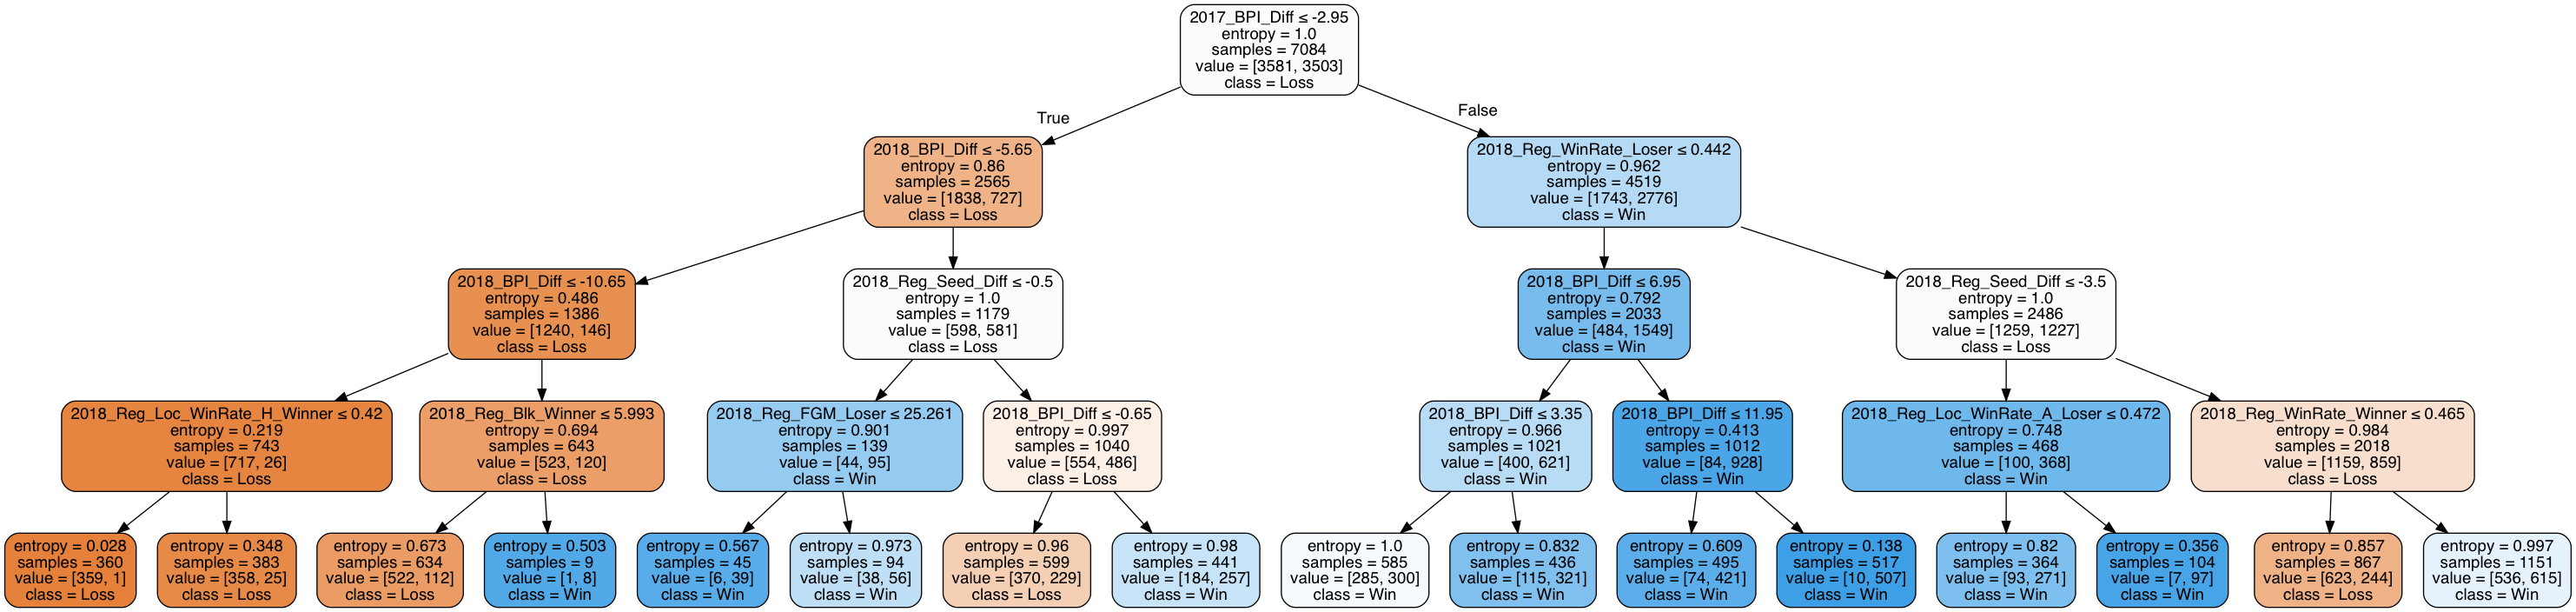

In [33]:
Plot_Tree(plot_tree)

-  Although this is not 100% the same, it still shows that BPI, WinRate, and Seed matter the most in it's decision making, although each ensemble in the forest model could be somewhat diffrent.

In [34]:
log_loss(y_train, rs_forest.predict_proba(X_train)), log_loss(y_hold, rs_forest.predict_proba(X_hold))

(0.4722986300400082, 0.48771499435530496)

In [35]:
accuracy_score(y_train, rs_forest.predict(X_train)),accuracy_score(y_hold, rs_forest.predict(X_hold))

(0.7595990965556183, 0.7574089754445386)

In [36]:
confusion_matrix(y_hold, rs_forest.predict(X_hold))

array([[867, 275],
       [298, 922]])

In [41]:
tn, fp, fn, tp = confusion_matrix(y_hold, rs_forest.predict(X_hold)).ravel()

In [42]:
pd.DataFrame(confusion_matrix(y_hold, rs_forest.predict(X_hold)))

,0,1
0,867,275
1,298,922


In [43]:
print(classification_report(y_hold, rs_forest.predict(X_hold)))

             precision    recall  f1-score   support

          0       0.74      0.76      0.75      1142
          1       0.77      0.76      0.76      1220

avg / total       0.76      0.76      0.76      2362



In [44]:
print("FPR = ", (fp / (fp + tn)).round(2))
print("TPR = ", (tp / (tp + fn)).round(2))

FPR =  0.24
TPR =  0.76


In [45]:
rs_forest.predict_proba(X_hold)[:,0]

array([0.04080611, 0.53053304, 0.58082905, ..., 0.62974458, 0.25232968,
       0.24205437])

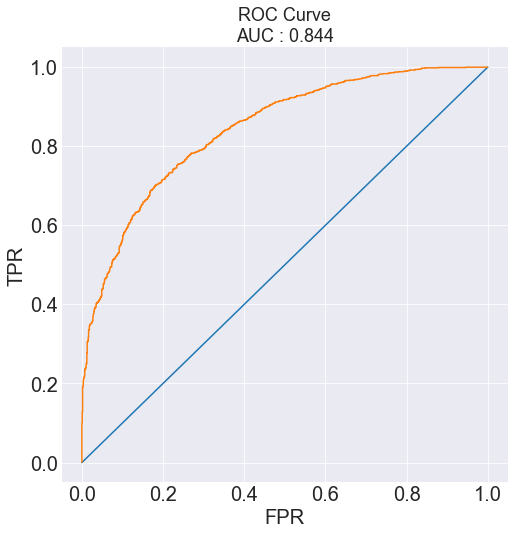

In [46]:
fpr, tpr, _ = roc_curve(y_hold, rs_forest.predict_proba(X_hold)[:,1])

plt.figure(figsize=(8,8))
plt.plot([0,1],[0,1])
plt.xlabel('FPR', fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('TPR', fontsize = 20)
plt.yticks(fontsize = 20)

rs_forest_auc = auc(fpr,tpr)

plt.title('ROC Curve\nAUC : ' + str(rs_forest_auc.round(3)), fontsize = 18)
plt.plot(fpr, tpr)

- This model scored 0.753653 on Kaggle, which is my best score thus far.  Although we're still mispredicting ~600/2000 games, the logloss overall improved through this method, since the underlying probability of each prediction is what matters most.  This is also somewhat representative of professional sports as well, since there's always going to be variability in playing games!  What holds true, however, is that the main teams that advance into the finals have high seeds, high BPI (or any other analytics-derived ranking such as ELO), and strong season stats are strong predictors for March Madness.

- EDIT:  My Kaggle submissions were backwards, I had to flip the 'Won' column.

In [47]:
##### 2018 Tournament Submission ####### 
sub_target = stage2_sample_sub[['ID']].copy()

sub_target['Season'] = sub_target['ID'].map(lambda x: int(x.split("_")[0]))
sub_target['TeamTeamID'] = sub_target['ID'].map(lambda x: int(x.split("_")[1]))
sub_target['OppTeamID'] = sub_target['ID'].map(lambda x: int(x.split("_")[2]))

sub_target.drop('ID', axis = 1, inplace = True)

target_df = sub_target.loc[sub_target['Season'] == 2018, ['TeamTeamID', 'OppTeamID']].reset_index(drop = True)

regstats2016_with_seed = StatGrabber_withSeed_withNCAA(df_reg, [2016], 'Reg')
regstats2017_with_seed = StatGrabber_withSeedNCAABPI(df_reg, [2017], 'Reg')
regstats2018_with_seed = StatGrabber_withSeedNCAABPI(df_reg, [2018], 'Reg')

train_df = SingleMerger(target_df, regstats2016_with_seed).copy()
train_df = SingleMerger(train_df, regstats2017_with_seed).copy()
train_df = SingleMerger(train_df, regstats2018_with_seed).copy()

train_df = MatchMaker(train_df).copy()

train_df['2016_Reg_Seed_Diff'] = train_df['2016_Reg_Seed_Winner'] - train_df['2016_Reg_Seed_Loser']
train_df['2017_Reg_Seed_Diff'] = train_df['2017_Reg_Seed_Winner'] - train_df['2017_Reg_Seed_Loser']
train_df['2018_Reg_Seed_Diff'] = train_df['2018_Reg_Seed_Winner'] - train_df['2018_Reg_Seed_Loser']

train_df['2017_BPI_Diff'] = train_df['2017_BPI_Winner'] - train_df['2017_BPI_Loser']
train_df['2018_BPI_Diff'] = train_df['2018_BPI_Winner'] - train_df['2018_BPI_Loser']

# train_df.drop([
#     '2016_Reg_Seed_Winner', '2016_Reg_Seed_Loser',\
#                '2017_Reg_Seed_Winner', '2017_Reg_Seed_Loser',\
#                '2018_Reg_Seed_Winner', '2018_Reg_Seed_Loser',\
#                 '2017_BPI_Winner','2017_BPI_Loser',\
#                 '2018_BPI_Winner','2018_BPI_Loser'\
#                 ],axis = 1, inplace = True)

X_test = train_df.copy().set_index('Match')


rs_forest.predict_proba(X_test)

array([[0.33082628, 0.66917372],
       [0.46175495, 0.53824505],
       [0.45355074, 0.54644926],
       ...,
       [0.92533684, 0.07466316],
       [0.42119692, 0.57880308],
       [0.07994608, 0.92005392]])

In [51]:
pred_2018_df = pd.DataFrame()

year = 2018
pred_2018_df['Season'] = [year for i in range(0,train_df.shape[0])]
pred_2018_df['TeamTeamID'] = sub_target['TeamTeamID'].copy()
pred_2018_df['OppTeamID'] = sub_target['OppTeamID'].copy()
pred_2018_df['Pred'] = rs_forest.predict_proba(X_test)[:,0]

Submission_IDMaker(pred_2018_df).loc[:,['ID','Pred']].reset_index(drop = True).to_csv('PRED_TEMP.csv', index = False)

In [52]:
from bracketeer import build_bracket
b = build_bracket(
        outputPath='output.png',
        teamsPath='./Teams.csv',
        seedsPath='./Stage2UpdatedDataFiles/NCAATourneySeeds.csv',
        submissionPath='./PRED_TEMP.csv',
        slotsPath='./Stage2UpdatedDataFiles/NCAATourneySlots.csv',
        year=2018
)

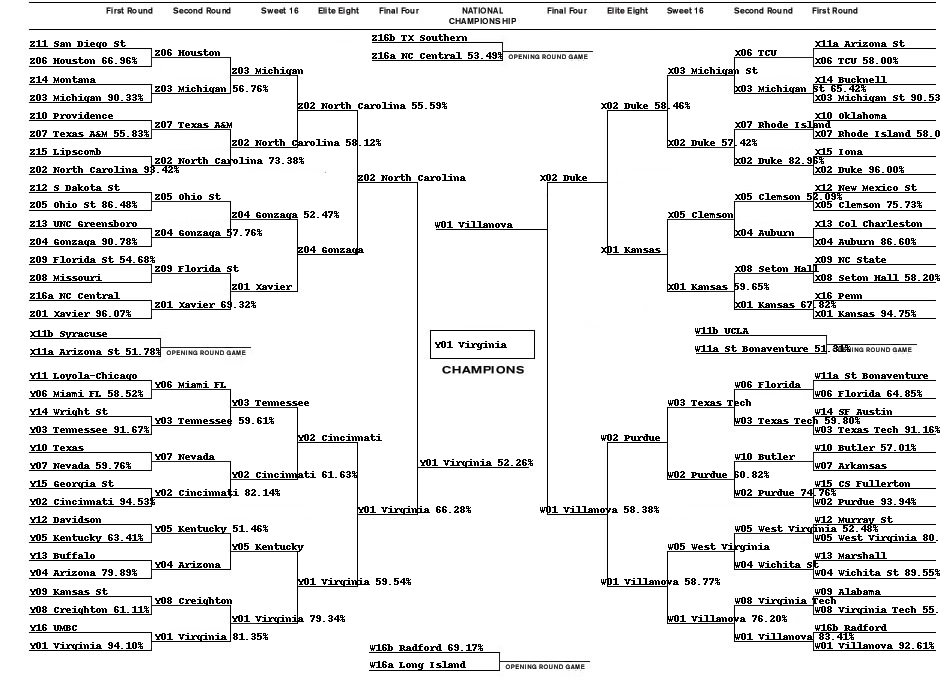

In [53]:
from IPython.display import Image
Image("output.png")